### Elevation trend analysis based on altimeter data.


In [30]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import h5py
from utils.ransac_fitting import ransac_fitting


In [20]:
path_sta_isat1 = 'data/icesat-1/stat_dif_isat1.nc'


In [44]:
stat_isat1_xr = xr.open_dataset(path_sta_isat1)
years = stat_isat1_xr.time.values
bins_id = stat_isat1_xr.bins_id.values
years
# bins_id



array(['2003', '2004', '2005', '2006', '2007', '2008', '2009'],
      dtype=object)

In [43]:
def stat_bins_weighting(mean_bins, std_bins, glacier_area_bins):
    """
    des: bins-based glacier area weighted elevation change calculation.
    args:
        mean_bins: xarray.DataArray, (bins_id, years), mean elevation change for each bin.
        std_bins: xarray.DataArray, (bins_id, years), standard deviation of elevation change for each bin.
        glacier_area_bins: xarray.DataArray, (bins_id), glacier area for each bin.
        years_data: list, contain the years of the data, e.g., [2001, 2002, 2003, ...]
        return: 
        mean_tilesWeighted: xr.dataarray, glacier-area weighted mean elevation change for overall setp. 
        std_tilesWeighted:  xr.dataarray, glacier-area weighted standard deviation of elevation change for overall setp.
    """
    ### glacier area (bin-based) weighted mean elevation change for setp.
    years = mean_bins.time.values
    bins_id = mean_bins.bins_id.values
    glacier_area_bins_2d = glacier_area_bins.expand_dims(dim={'times': years}, axis=1)  ## (bins_id, years)
    glacier_area_bins_2d = ~np.isnan(mean_bins)*glacier_area_bins_2d.values  ## (bins_id, years), mask the nan values before area weighting
    glacier_area_1d = glacier_area_bins_2d.sum(dim=('bins_id'))   ### (years,)    
    glacier_area_2d = glacier_area_1d.expand_dims(dim={'bins_id': bins_id}, axis=0)   ### (bins_id, years)    
    glacier_area_binsWeight_2d = glacier_area_bins_2d/glacier_area_2d   ### (bins_id, years)
    mean_binsWeighted = mean_bins*glacier_area_binsWeight_2d    ## (bins_id, years)
    mean_binsWeighted = mean_binsWeighted.sum(dim=('bins_id'))     ## (years,)   
    std_binsWeighted = std_bins*glacier_area_binsWeight_2d    ## (bins_id, years)
    std_binsWeighted = std_binsWeighted.sum(dim=('bins_id'))     ## (years,)   
    return mean_binsWeighted, std_binsWeighted



In [47]:
mean_binsWeighted, std_binsWeighted = stat_bins_weighting(mean_bins=stat_isat1_xr['mean_glacier_bins'], \
                                std_bins=stat_isat1_xr['std_glacier_bins'], glacier_area_bins=stat_isat1_xr['area_glacier_bins'])

y_filtered_setp_glacier, y_fitting_setp_glacier, ransac_coef_setp_glacier = ransac_fitting(x=np.arange(len(years)), y=mean_binsWeighted.values, thre_mask=50)
print(ransac_coef_setp_glacier)


[-0.6471749]


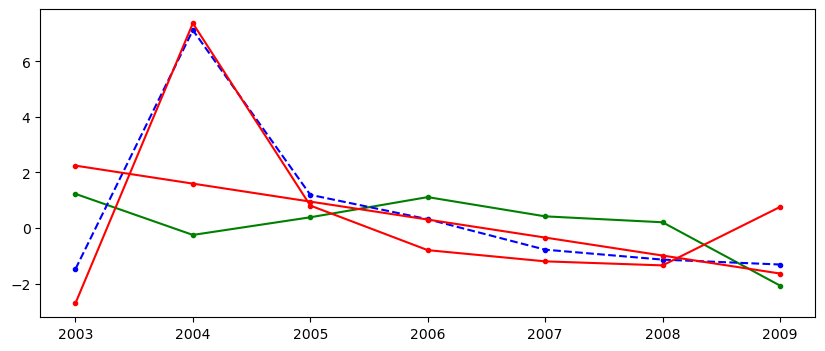

In [46]:
years = ['2003', '2004', '2005', '2006', '2007', '2008', '2009']
plt.figure(figsize=(10,4))
plt.plot(years, stat_isat1_xr['mean_stable_bins'].values, '.-g', label='mean_dif on stable region')
plt.plot(years, mean_binsWeighted, '.--b', label='mean_dif on glacier region')
plt.plot(years, mean_binsWeighted-stat_isat1_xr['mean_stable_bins'].values, '.-r', label='corrected mean_dif on glacier region')
plt.plot(years, y_fitting_setp_glacier, '.-r', label='corrected mean_dif fitting on glacier region')


